# Cohort 7.3 Mass Spec AUCs & ratios analysis

### Imports and environment setup

- Date of run: 2025-05-22
- Environment: python 3.12
- Packages required: pandas, numpy, sklearn, statsmodels, seaborn, matplotlib

In [1]:
# Include in the environment the code directory with the utils function
import sys
sys.path.append('../code/')

In [2]:
# Library imports
import pandas as pd
import numpy as np
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# import all functions from ../code/cohort_analysis_utils.py
import cohort_analysis_utils as utils

In [3]:
# Remove warnings for readability
import warnings
warnings.filterwarnings('ignore')

# Remove cell printing limits
pd.set_option('display.max_rows', None)

# Data loading and preprosessing

## PG matrix

In [4]:
df = pd.read_csv('../data/ms/cohort_7_3_MS_pg.csv', index_col='Protein.Names', header=0, sep='\t')

In [5]:
# Name harmonization
df.columns = list(df.columns[0:3]) + \
             [ c.replace('/users/pr/rawstream/2025NK011/mzml/', '')[0:len("2025NK011_EVCO_001")] for c in df.columns[3:] ]

In [6]:
# Convert to numeric 
df.iloc[:, 3:] = df.iloc[:, 3:].replace(0, np.nan)
df.iloc[:, 3:] = df.iloc[:, 3:].apply(pd.to_numeric, errors='coerce')

In [7]:
# Remove the first 3 columns, keeping only the protein names as columns
df = df.iloc[:, 3:]

In [8]:
# Keep a log2 transformation of the data
df = np.log2(df)

In [9]:
# Transpose, columns are now proteins and rows are samples, as in ELISA
df = df.T

In [10]:
######## Remove rows from df that have less than 5000 non-NaN values ########
df_116 = df.copy()
df = df.dropna(thresh=5000)


In [11]:
######## NORMALIZATION TO THE MEDIAN ########
df = df.subtract(df.median(axis=1), axis=0)

In [12]:
# The biomarkers are now the columns of the dataframe
BIOMARKERS = list(df.columns)

### Metadata

In [13]:
df_metadata = pd.read_csv('../data/cohort_7.3_metadata.csv', index_col='id_ms', header=0, sep='\t')

In [27]:
df['Pathology'] = df_metadata['Pathology']
df['Endometrial_thickness'] = df_metadata['Endometrial_thickness']

df_116['Pathology'] = df_metadata['Pathology']
df_116['Endometrial_thickness'] = df_metadata['Endometrial_thickness']

In [15]:
df.head()

Protein.Names,NUD4B_HUMAN,KV37_HUMAN,LV469_HUMAN,LV861_HUMAN,LV460_HUMAN,LVX54_HUMAN,LV548_HUMAN,LV746_HUMAN,LV537_HUMAN,LV322_HUMAN,...,SCC4_HUMAN,F169A_HUMAN,ENPP4_HUMAN,ZHX2_HUMAN,MORC2_HUMAN,NS1BP_HUMAN,S23IP_HUMAN,COL10_HUMAN,Pathology,Endometrial_thickness
2025NK011_EVCO_001,NaN,8.503412,8.191344,6.744697,3.968654,NaN,-0.711087,8.261095,0.667425,NaN,...,NaN,-2.226320,-2.510777,-0.511778,-1.806653,-2.358029,-0.019718,-2.354596,0.0,42.0
2025NK011_EVCO_002,NaN,7.387199,6.012501,6.191824,-0.756886,NaN,-1.932774,6.088268,-1.509365,NaN,...,NaN,-1.084612,-0.502881,-0.396890,-2.467624,-0.877516,-0.036994,-2.946345,1.0,6.0
2025NK011_EVCO_004,NaN,8.186114,6.491853,3.839204,2.611763,NaN,NaN,6.204571,-0.715212,NaN,...,NaN,-0.773635,-1.252063,-0.855547,-2.112104,-0.699431,0.786596,-3.673083,0.0,6.0
2025NK011_EVCO_005,-2.730646,7.809866,6.949269,5.861213,5.173829,NaN,NaN,7.590085,0.982298,NaN,...,NaN,-0.920351,-1.543012,-0.270089,-2.022421,-1.405551,1.017487,-2.858068,0.0,4.0
2025NK011_EVCO_006,NaN,7.701804,6.862866,5.804819,5.217739,NaN,NaN,7.378455,1.512206,NaN,...,-4.915425,-1.305806,-2.316499,-0.367265,-0.792234,-0.588216,1.326651,-1.051796,1.0,11.0


In [16]:
df = df.dropna(subset=['Pathology'])

In [17]:
# It is the expected shape of the dataframe?
df.shape

(105, 11072)

### Compute biomarker AUCs and Log2FC 

This allow us check we're in the same page that CRG computations

In [18]:
from sklearn.metrics import roc_auc_score, roc_curve
from scipy.stats import mannwhitneyu  # Add this import

import numpy as np

auc_scores = {}
sensitivity_max_sum = {}
specificity_max_sum = {}
sensitivity_high = {}
specificity_for_high_sens = {}
threshold_max_sum = {}
threshold_high_sens = {}
log2FC = {}
n_pos = {}
n_neg = {}

for biomarker in BIOMARKERS:
    if df[biomarker].isnull().any():
        # Ignore Nans in the biomarker column and get the corresponding Pathology values
        y_true = df.Pathology[df[biomarker].notnull()]
        y_score = df[biomarker][df[biomarker].notnull()]
        #print(f"Processing biomarker: {biomarker} with NaNs removed")
    else:
        y_true = df.Pathology
        y_score = df[biomarker]
    
    if len(y_true) == 0 or len(y_score) == 0:
        continue 
        
    auc = roc_auc_score(y_true, y_score)
    
    # Check if AUC < 0.5, invert if needed
    invert = False
    if auc < 0.5:
        invert = True
        auc = 1 - auc
        y_score = -y_score  # Invert the prediction scores
    
    # Calculate ROC curve points
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    
    # Specificity = 1 - fpr
    specificity = 1 - fpr
    
    # Criterion 1: Find threshold that maximizes (sensitivity + specificity)
    sum_sens_spec = tpr + specificity
    optimal_idx = np.argmax(sum_sens_spec)
    
    # Criterion 2: Find threshold with max specificity where sensitivity > 0.95
    high_sens_indices = np.where(tpr >= 0.95)[0]
    if len(high_sens_indices) > 0:
        high_sens_optimal_idx = high_sens_indices[np.argmax(specificity[high_sens_indices])]
        sens_high = tpr[high_sens_optimal_idx]
        spec_high = specificity[high_sens_optimal_idx]
        thresh_high = thresholds[high_sens_optimal_idx] if high_sens_optimal_idx < len(thresholds) else np.nan
    else:
        sens_high = np.nan
        spec_high = np.nan
        thresh_high = np.nan

    # # Calculate p-value using Mann-Whitney U test
    # group_0 = df[df['Pathology'] == 0][biomarker]
    # group_1 = df[df['Pathology'] == 1][biomarker]
    # try:
    #     stat, p_value = mannwhitneyu(group_0, group_1)
    #     pvalues[biomarker] = round(float(p_value), 6)
    # except:
    #     pvalues[biomarker] = np.nan

    # Store results
    auc_scores[biomarker] = round(float(auc), 3)
    sensitivity_max_sum[biomarker] = round(float(tpr[optimal_idx]), 3)
    specificity_max_sum[biomarker] = round(float(specificity[optimal_idx]), 3)
    sensitivity_high[biomarker] = round(float(sens_high), 3)
    specificity_for_high_sens[biomarker] = round(float(spec_high), 3)
    threshold_max_sum[biomarker] = round(float(thresholds[optimal_idx] if optimal_idx < len(thresholds) else np.nan), 3)
    threshold_high_sens[biomarker] = round(float(thresh_high), 3)
    log2FC[biomarker] = round(float(df[biomarker].groupby(df['Pathology']).mean().diff().iloc[-1]), 3)
    n_pos[biomarker] = df[df.Pathology == 1][biomarker].count()
    n_neg[biomarker] = df[df.Pathology == 0][biomarker].count()
    
# Sort by AUC
auc_scores = dict(sorted(auc_scores.items(), key=lambda item: item[1], reverse=True))

# Create dataframe with all metrics
result_df = pd.DataFrame({
    'Biomarker': list(auc_scores.keys()),
    'AUC': list(auc_scores.values()),
    'Sensitivity (max sum)': [sensitivity_max_sum[biomarker] for biomarker in auc_scores.keys()],
    'Specificity (max sum)': [specificity_max_sum[biomarker] for biomarker in auc_scores.keys()],
    #'Threshold (max sum)': [threshold_max_sum[biomarker] for biomarker in auc_scores.keys()],
    'Sensitivity (sens > 95%)': [sensitivity_high[biomarker] for biomarker in auc_scores.keys()],
    'Specificity (sens > 95%)': [specificity_for_high_sens[biomarker] for biomarker in auc_scores.keys()],
    #'Threshold (high sens)': [threshold_high_sens[biomarker] for biomarker in auc_scores.keys()],
    'Log2FC': [log2FC[biomarker] for biomarker in auc_scores.keys()],
    #'p-value': [pvalues[biomarker] for biomarker in auc_scores.keys()],
    #'Adjusted p-value': [adjusted_pvalues[biomarker] for biomarker in auc_scores.keys()],
    'n_pos': [n_pos[biomarker] for biomarker in auc_scores.keys()],
    'n_neg': [n_neg[biomarker] for biomarker in auc_scores.keys()]
})

In [19]:
# Set mimark biomarkers to check if results are consistent with the CRG data
MMK_BIOMARKERS = ["AGRIN_HUMAN", "MMP9_HUMAN", "TIMP2_HUMAN", 
                    "KPYM_HUMAN", "PERM_HUMAN", "MVP_HUMAN", "NGAL_HUMAN", "CLIC1_HUMAN", 
                    "PIGR_HUMAN"]

result_df_mmk = result_df[result_df['Biomarker'].isin(MMK_BIOMARKERS)]
result_df_mmk = result_df_mmk.sort_values(by='AUC', ascending=False)
result_df_mmk

,Biomarker,AUC,Sensitivity (max sum),Specificity (max sum),Sensitivity (sens > 95%),Specificity (sens > 95%),Log2FC,n_pos,n_neg
2107,KPYM_HUMAN,0.876,0.923,0.679,0.962,0.415,0.963,52,53
350,CLIC1_HUMAN,0.810,0.615,0.887,0.962,0.208,0.659,52,53
352,AGRIN_HUMAN,0.797,0.615,0.887,0.962,0.226,1.158,52,53
2249,MMP9_HUMAN,0.727,0.750,0.642,0.962,0.264,1.376,52,53
1766,PERM_HUMAN,0.698,0.731,0.679,0.981,0.170,1.377,52,53
2122,TIMP2_HUMAN,0.679,0.635,0.642,0.981,0.264,-0.681,52,53
4159,MVP_HUMAN,0.667,0.615,0.717,0.962,0.038,0.744,52,53
1588,PIGR_HUMAN,0.655,0.750,0.528,0.962,0.113,-1.074,52,53
5419,NGAL_HUMAN,0.586,0.635,0.585,1.000,0.000,-0.523,52,53


## MMK Ratios models

In [20]:
# Compute ratios between MMK_BIOMARKERS
ratios = []
for bmk in MMK_BIOMARKERS:
    for bmk2 in MMK_BIOMARKERS:
        if bmk != bmk2:
            ratio_name = f"{bmk.replace("_HUMAN","")}_{bmk2.replace("_HUMAN","")}"
            # Substracting because the biomarkers are already log2 transformed
            df[ratio_name] = df[bmk] - df[bmk2]
            ratios.append(ratio_name)

In [21]:
df_mmk_ratios = df[ratios + ['Pathology', 'Endometrial_thickness']]

In [22]:
RESULTS_PATH = f'../data/results/cohort_7_3_MS/ratios_mmk_et_105/'
apply_log = False
NORMALIZING_COL = '' 
VOLUME_COL = ''
METHODS = ['direct']

for biomarker_count in range(1, 3):
    print(f'Number of biomarkers: {biomarker_count}')
    #print(results_path_complete)
    models = utils.compute_all_models_and_save(
                                df=df_mmk_ratios,
                                biomarkers=['Endometrial_thickness'] + ratios,
                                normalizing_col=NORMALIZING_COL, 
                                volume_col= VOLUME_COL,
                                volume_added=0.5,
                                apply_log=apply_log,
                                avoid_same_biomarker=True,
                                methods=METHODS,
                                max_biomarker_count=biomarker_count,
                                folder_name=RESULTS_PATH,
                                plot_rocs=True if biomarker_count < 3 else False,
                                auc_threshold=0.7 + 0.1 * biomarker_count,
                                compute_auc_ci=False, #True if biomarker_count == 1 else False,
                                )

    # if biomarker_count == 1:
    #     # Reserve the models with confidence intervals for the final analysis
    #     models_with_auc_ci = models
    
    print(f'Number of biomarkers: {biomarker_count} done')


Number of biomarkers: 1
Number of biomarkers: 1 done
Number of biomarkers: 2
Could not fit the model for biomarkers: ['AGRIN_MMP9', 'MMP9_AGRIN']
Singular matrix
Could not fit the model for biomarkers: ['AGRIN_TIMP2', 'TIMP2_AGRIN']
Singular matrix
Could not fit the model for biomarkers: ['AGRIN_KPYM', 'KPYM_AGRIN']
Singular matrix
Could not fit the model for biomarkers: ['AGRIN_PERM', 'PERM_AGRIN']
Singular matrix
Could not fit the model for biomarkers: ['AGRIN_MVP', 'MVP_AGRIN']
Singular matrix
Could not fit the model for biomarkers: ['AGRIN_NGAL', 'NGAL_AGRIN']
Singular matrix
Could not fit the model for biomarkers: ['AGRIN_CLIC1', 'CLIC1_AGRIN']
Singular matrix
Could not fit the model for biomarkers: ['AGRIN_PIGR', 'PIGR_AGRIN']
Singular matrix
Could not fit the model for biomarkers: ['MMP9_TIMP2', 'TIMP2_MMP9']
Singular matrix
Could not fit the model for biomarkers: ['MMP9_KPYM', 'KPYM_MMP9']
Singular matrix
Could not fit the model for biomarkers: ['MMP9_PERM', 'PERM_MMP9']
Singul

### MMK Ratios, 116 samples

In [28]:
# Compute ratios between MMK_BIOMARKERS
ratios = []
for bmk in MMK_BIOMARKERS:
    for bmk2 in MMK_BIOMARKERS:
        if bmk != bmk2:
            ratio_name = f"{bmk.replace("_HUMAN","")}_{bmk2.replace("_HUMAN","")}"
            # Substracting because the biomarkers are already log2 transformed
            df_116[ratio_name] = df_116[bmk] - df_116[bmk2]
            ratios.append(ratio_name)

df_mmk_ratios_116 = df_116[ratios + ['Pathology', 'Endometrial_thickness']]

In [29]:
RESULTS_PATH = f'../data/results/cohort_7_3_MS/ratios_mmk_et_116/'
apply_log = False
NORMALIZING_COL = '' 
VOLUME_COL = ''
METHODS = ['direct']

for biomarker_count in range(1, 3):
    print(f'Number of biomarkers: {biomarker_count}')
    #print(results_path_complete)
    models = utils.compute_all_models_and_save(
                                df=df_mmk_ratios_116,
                                biomarkers=['Endometrial_thickness'] + ratios,
                                normalizing_col=NORMALIZING_COL, 
                                volume_col= VOLUME_COL,
                                volume_added=0.5,
                                apply_log=apply_log,
                                avoid_same_biomarker=True,
                                methods=METHODS,
                                max_biomarker_count=biomarker_count,
                                folder_name=RESULTS_PATH,
                                plot_rocs=True if biomarker_count < 3 else False,
                                auc_threshold=0.7 + 0.1 * biomarker_count,
                                compute_auc_ci=False, #True if biomarker_count == 1 else False,
                                )

    # if biomarker_count == 1:
    #     # Reserve the models with confidence intervals for the final analysis
    #     models_with_auc_ci = models
    
    print(f'Number of biomarkers: {biomarker_count} done')

Number of biomarkers: 1
Number of biomarkers: 1 done
Number of biomarkers: 2
Could not fit the model for biomarkers: ['AGRIN_MMP9', 'MMP9_AGRIN']
Singular matrix
Could not fit the model for biomarkers: ['AGRIN_TIMP2', 'TIMP2_AGRIN']
Singular matrix
Could not fit the model for biomarkers: ['AGRIN_KPYM', 'KPYM_AGRIN']
Singular matrix
Could not fit the model for biomarkers: ['AGRIN_PERM', 'PERM_AGRIN']
Singular matrix
Could not fit the model for biomarkers: ['AGRIN_NGAL', 'NGAL_AGRIN']
Singular matrix
Could not fit the model for biomarkers: ['AGRIN_CLIC1', 'CLIC1_AGRIN']
Singular matrix
Could not fit the model for biomarkers: ['AGRIN_PIGR', 'PIGR_AGRIN']
Singular matrix
Could not fit the model for biomarkers: ['MMP9_TIMP2', 'TIMP2_MMP9']
Singular matrix
Could not fit the model for biomarkers: ['MMP9_KPYM', 'KPYM_MMP9']
Singular matrix
Could not fit the model for biomarkers: ['MMP9_PERM', 'PERM_MMP9']
Singular matrix
Could not fit the model for biomarkers: ['MMP9_MVP', 'MVP_MMP9']
Singular

### Comparing wrongly predicted samples


In [38]:
def plot_variable_by_cohort_pathology_with_outlier_labels(
    combined_df,
    variable_name,
    y_label,
    title,
    label_column=None,  # Column to use for labels, None defaults to index
    yscale='linear',
    figsize=(12, 8)
):
    """
    Plot a traditional boxplot showing outliers with smart label positioning and arrows.
    
    Args:
        combined_df: DataFrame containing the data
        variable_name: Name of the variable to plot
        y_label: Label for the y-axis
        title: Title for the plot
        label_column: Column to use for outlier labels (defaults to dataframe index if None or if column doesn't exist)
        yscale: Scale for the y-axis ('linear' or 'log')
        figsize: Size of the figure as a tuple (width, height)
    """
    fig, ax = plt.subplots(figsize=figsize)
    
    # Check if label_column exists in DataFrame
    use_index_for_labels = True
    if label_column is not None and label_column in combined_df.columns:
        use_index_for_labels = False
    else:
        if label_column is not None:
            print(f"Warning: Column '{label_column}' not found in DataFrame. Using row indices for labels.")
        label_column = None
    
    # Create the boxplot with outliers shown
    boxplot = sns.boxplot(
        x="Pathology", 
        y=variable_name, 
        data=combined_df,
        palette=['pink', 'red'],  # Custom colors for pathology groups
        showfliers=True,  # Show outlier markers
        ax=ax
    )
    
    # Create a dictionary to track label positions per group to avoid overlaps
    used_positions = {}
    
    # Process each pathology group
    for i, pathology_group in enumerate(combined_df["Pathology"].unique()):
        used_positions[i] = []
        group_data = combined_df[combined_df["Pathology"] == pathology_group]
        group_values = group_data[variable_name].dropna()
        if group_values.empty:
            continue  # Skip this group if no data

        q1 = np.percentile(group_values, 25)
        q3 = np.percentile(group_values, 75)
        iqr = q3 - q1
        
        # Define outlier bounds
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        
        # Find outliers
        outliers = group_data[(group_data[variable_name] < lower_bound) | 
                             (group_data[variable_name] > upper_bound)]
        
        # Add annotation for each outlier using its actual value
        for idx, row in outliers.iterrows():
            # Determine the label to use
            if not use_index_for_labels:
                label = str(row[label_column])
            else:
                label = str(idx)
            
            # Get the y value of this outlier
            y_coord = row[variable_name]
            
            # Position the label to the right of the point, avoiding overlaps
            offset_y = 0
            label_pos = (y_coord + offset_y)
            
            # Check for position overlap with existing labels
            while any(abs(pos - label_pos) < 0.05 * (upper_bound - lower_bound) for pos in used_positions[i]):
                offset_y += 0.05 * (upper_bound - lower_bound)  # Increase offset to avoid overlap
                label_pos = y_coord + offset_y
            
            # Save this label position
            used_positions[i].append(label_pos)
            
            # Add annotation with arrow connecting to data point
            ax.annotate(
                label,
                xy=(i, y_coord),  # Target point (the data point)
                xytext=(i + 0.3, label_pos),  # Position of text (offset to the right)
                fontsize=9,
                color='red',
                weight='bold',
                arrowprops=dict(
                    arrowstyle="->",
                    connectionstyle="arc3,rad=0.2",
                    color='red',
                    alpha=0.7,
                    linewidth=0.8
                )
            )
    
    plt.title(title, fontsize=16)
    plt.ylabel(y_label, fontsize=14)
    plt.xlabel('', fontsize=14)  # Hide the x-label as it's already clear from the plot
    
    if yscale == 'log':
        plt.yscale('log')
    
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

In [39]:
model = models["direct"][list(models["direct"].keys())[0]][('Endometrial_thickness', 'AGRIN_TIMP2')]['model']

In [40]:
X = sm.add_constant(df_116[['Endometrial_thickness', 'AGRIN_TIMP2']], has_constant='add')
df_with_pred = df_116.copy()
df_with_pred['Pathology_pred'] = model.predict(X)

In [46]:
combined_df = df_with_pred.merge(
    df_metadata[['sample']],
    left_index=True,
    right_index=True,
    how='left'
)

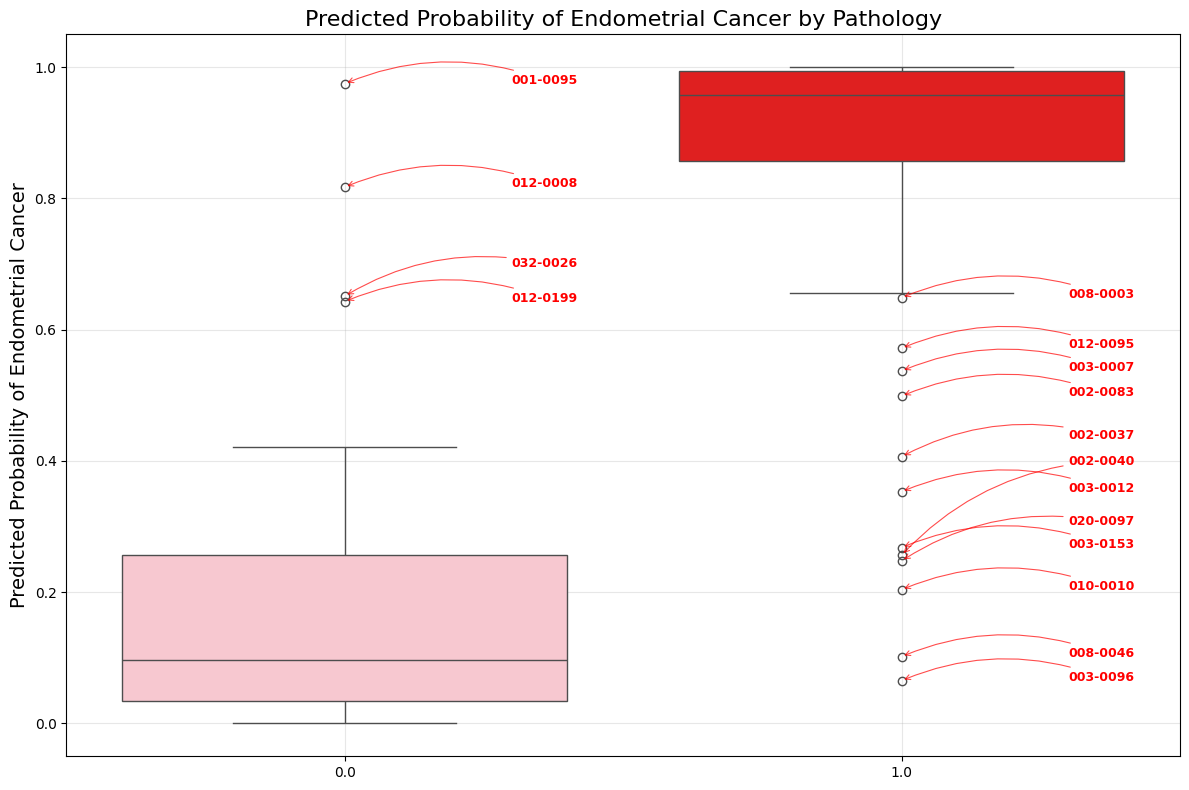

In [47]:
# Plot probabilities by pathology with labeled outliers - traditional boxplot style
plot_variable_by_cohort_pathology_with_outlier_labels(
    combined_df=combined_df,
    variable_name='Pathology_pred',
    y_label='Predicted Probability of Endometrial Cancer',
    title='Predicted Probability of Endometrial Cancer by Pathology',
    label_column='sample',
    yscale='linear'
)

### Compute models for all the 116 ratios

In [67]:
# Compute ratios between MMK_BIOMARKERS
ratios = []
i = 0

high_auc_biomarkers = result_df[result_df['AUC'] > 0.9]['Biomarker'].tolist()

for bmk in high_auc_biomarkers:
    for bmk2 in high_auc_biomarkers:
        if bmk != bmk2:
            # Compute the ratio only if bmk and bmk2 are not-nan in at least 
            # 90% of the samples
            if df[bmk].notnull().sum() >= 0.95 * len(df) and df[bmk2].notnull().sum() >= 0.95 * len(df):
                # Only compute ratio bmk_bmk2 if bmk2_bmk is not already computed
                if f"{bmk2}_{bmk}" not in ratios:
                    ratio_name = f"{bmk.replace("_HUMAN","")}_{bmk2.replace("_HUMAN","")}"
                    # Substracting because the biomarkers are already log2 transformed
                    df_116[ratio_name] = df_116[bmk] - df_116[bmk2]
                    ratios.append(ratio_name)
        
        # if len(ratios) % 100 == 0:
        #     print(f"Computed {len(ratios)} ratios so far...")
    
    i += 1
    if i % 25 == 0:
        print(f"Processed {i} of {len(high_auc_biomarkers)} biomarkers and computed {len(ratios)} ratios...")

df_all_ratios_116 = df_116[ratios + ['Pathology', 'Endometrial_thickness']]

Processed 25 of 316 biomarkers and computed 284 ratios...
Processed 50 of 316 biomarkers and computed 1420 ratios...
Processed 75 of 316 biomarkers and computed 2201 ratios...
Processed 100 of 316 biomarkers and computed 2769 ratios...
Processed 125 of 316 biomarkers and computed 3337 ratios...
Processed 150 of 316 biomarkers and computed 3763 ratios...
Processed 175 of 316 biomarkers and computed 3905 ratios...
Processed 200 of 316 biomarkers and computed 3905 ratios...
Processed 225 of 316 biomarkers and computed 4189 ratios...
Processed 250 of 316 biomarkers and computed 4473 ratios...
Processed 275 of 316 biomarkers and computed 4686 ratios...
Processed 300 of 316 biomarkers and computed 5041 ratios...


In [68]:
RESULTS_PATH = f'../data/results/cohort_7_3_MS/ratios_all_116/'
apply_log = False
NORMALIZING_COL = '' 
VOLUME_COL = ''
METHODS = ['direct']

for biomarker_count in [1]:
    print(f'Number of biomarkers: {biomarker_count}')
    #print(results_path_complete)
    models = utils.compute_all_models_and_save(
                                df=df_all_ratios_116,
                                biomarkers=ratios,
                                normalizing_col=NORMALIZING_COL, 
                                volume_col= VOLUME_COL,
                                volume_added=0.5,
                                apply_log=apply_log,
                                avoid_same_biomarker=True,
                                methods=METHODS,
                                max_biomarker_count=biomarker_count,
                                folder_name=RESULTS_PATH,
                                plot_rocs=True,
                                auc_threshold=0.92,
                                compute_auc_ci=False, #True if biomarker_count == 1 else False,
                                )
    
    print(f'Number of biomarkers: {biomarker_count} done')

Number of biomarkers: 1
Number of biomarkers: 1 done
